In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
import time 
%matplotlib inline

# $\star$ $\star$  Question 1
Implement the message passing method in the disparity estimation setting. Each pixel can take 16 labels (disparities in the Tsukuba pair range from 0 to 15).

For the unary cost take the Euclidean distance between the pixel colors in the two images. For each pixel in the left image, you must compute 16 costs corresponding to the 16 disparity options.

Consider the image as an undirected graph, where all pixels are connected only to their direct left and right neighbor. For the pairwise potential use the Potts model (0 cost if the disparity is the same, LAMBDA else). 

Run the message passing algorithm to find the solution with the highest probability. Visualize this result and play with the parameter LAMBDA.

## Load and visualize input images

In [2]:
imgL = np.array(Image.open("../data/tsukubaL.ppm"))
imgR = np.array(Image.open("../data/tsukubaR.ppm"))

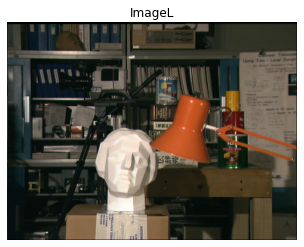

(-0.5, 383.5, 287.5, -0.5)

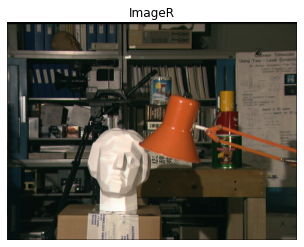

In [3]:
plt.title("ImageL")
plt.imshow(imgL)
plt.axis('off')
plt.show()
plt.title("ImageR")
plt.imshow(imgR)
plt.axis('off')

## Disparity estimation via message passing:

In [4]:
MAX_DISP = 16 
LAMBDA = 100.0 

class Timer():
    def __init__(self):
        self.start = None
        self.end = None
          
    def __enter__(self):
        self.start = time.time()
        return self
      
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.end = time.time()
        print('elasped secs: {:.2f}'.format(self.end - self.start))

    
def compute_unary_costs(imgL, imgR, max_disp=MAX_DISP):
    """
    Computes unary costs for disparity matching between two images.
    
    Args:
        imgL: Left image as numpy array with shape (h,w,3).
        imgL: Right image as numpy array with shape (h,w,3).
        max_disp: Maximal considered disparity.
        
    Returns:
        Unary costs for all considered disparities as numpy array of shape (h,w,max_disp).
    """
    h, w, _ = imgL.shape
    cost = np.zeros((h,w, max_disp))
    for y in range(0, h):
        for x in range(0, w):
            for d in range(0, max_disp):
                if x-d >=0:
                    cost[y,x,d] = np.linalg.norm(imgL[y,x] - imgR[y,x-d])
                else:
                    cost[y,x,d] = 1e9
    return cost
        

def potts_model(d1, d2, l=LAMBDA):
    """
    Computes the potts model cost for a pair of disparity values.
    """
    if d1 == d2:
        return 0.
    else:
        return l 


def compute_msg_fwd(unary_costs, max_disp=MAX_DISP):
    """
    Computes pairwise costs for disparity matching via message passing in the forward direction.
        
    Returns:
        Pairwise costs in the forward direction for all considered disparities as numpy array 
        of shape (h,w,max_disp).
    """
    h, w , _ = unary_costs.shape
    msgs = np.zeros((h,w, max_disp))
    for y in range(0, h):    
        for x in range(1, w):
            for i in range(0, max_disp):
                costs = []
                for j in range(0, max_disp):
                    cost = unary_costs[y,x-1,j] + potts_model(i,j) + msgs[y,x-1,j]
                    costs.append(cost)
                msgs[y,x,i] = min(costs)
    return msgs


def compute_msg_bwd(unary_costs, max_disp=MAX_DISP):
    """
    Computes pairwise costs for disparity matching via message passing in the backward direction.
        
    Returns:
        Pairwise costs in the backward direction for all considered disparities as numpy array 
        of shape (h,w,max_disp).
    """
    h, w , _ = unary_costs.shape
    msgs = np.zeros((h,w, max_disp))
    for y in range(0, h):    
        for x in range(w-2, -1, -1):
            for i in range(0, max_disp):
                costs = []
                for j in range(0, max_disp):
                    cost = unary_costs[y,x+1,j] + potts_model(i,j) +  msgs[y,x+1,j]
                    costs.append(cost)
                msgs[y,x,i] = min(costs)
    return msgs


def compute_disparity(imgL, imgR):
    """
    Computes the disparity between two images via message passing.
    
    Args:
        imgL: Left image as numpy array with shape (h,w,3).
        imgL: Right image as numpy array with shape (h,w,3).
        
    Returns:
        Disparity between two images as numpy array with shape (h,w).
    """
    h , w,_ = imgL.shape
    imgL = imgL.astype(np.float32)
    imgR = imgR.astype(np.float32)
    
    print("Precomputing data costs:")
    with Timer():
        unary_costs = compute_unary_costs(imgL, imgR)
    
    print("Precomputing forward messages:")
    with Timer():
        msg_fwd = compute_msg_fwd(unary_costs)
    print("Precomputing backward messages:")
    with Timer():
        msg_bwd = compute_msg_bwd(unary_costs)
    
    print("Computing disparity map:")
    with Timer():
        cost = unary_costs + msg_fwd + msg_bwd
        disparity_map = cost.argmin(axis=-1) 
    return disparity_map 


def show_disparity_map(disp):
    plt.imshow(disparity_map)
    plt.colorbar()
    plt.axis("off")

## Compute disparity map without belief propagation

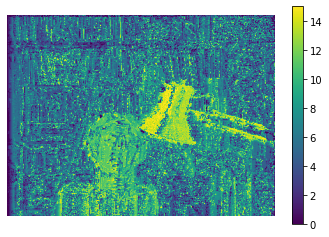

In [5]:
data_cost = compute_unary_costs(imgL, imgR)
disparity_map = data_cost.argmin(axis=-1)
show_disparity_map(disparity_map)

## Now compute disparity map with belief propagation...

Precomputing data costs:
elasped secs: 6.94
Precomputing forward messages:
elasped secs: 15.18
Precomputing backward messages:
elasped secs: 15.06
Computing disparity map:
elasped secs: 0.01


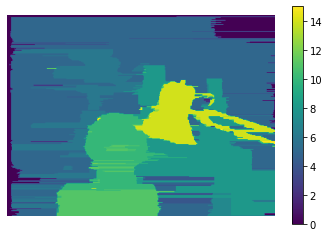

In [6]:
disparity_map = compute_disparity(imgL, imgR)
show_disparity_map(disparity_map)

## Some things to explore further: 
* Vectorize the solution and measure speedup or even implement in it C/C++. 
* Play around  with regularization term. 
* Play around with the data term.